# Optimization Test

The goal of this notebook is optimizate de potential energy in function of the displacement.

In [1]:
## Import libraires
import jax
import optax
from jax.scipy.special import logsumexp
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pyvista as pv
import Elements as EL
import Material as mat
from Functions import *
from jax import random
import numpy as np
from jax import config
config.update("jax_enable_x64", True)
key = random.key(0)


2024-05-15 11:13:47.079695: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## First Test: Minimize the potential energy, only internal energy consideration

### Unit Block test

In [2]:
#Mesh SET

mesh_file = '/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Meshes/cubo.msh'
mesh = pv.read(mesh_file)  #Orgiinal File
mesh.clear_data()

points_total,connectivity_total,bc_drichlet_cells,bc_neumann_cells = Hex_Reader(mesh_file,
                                                                                drichlet_bc= ["X_1"],plot = False)


#Dritchlet condition 
bc_drichlet_cells['X_1'] = [bc_drichlet_cells['X_1'], jnp.array([1,0,0]) ]

constant = [0.03,3.77]
material = mat.Delphino(constant,100)
malla = EL.Hexs(material, points_total,connectivity_total)

In [92]:
### Optimization 
#result = result.at[:4, :].set(0)
### Loss function
@jit
def loss_function(disp):
    disp = u(disp)
    constant = material.constants
    energia_externa = malla.External_Energy(disp, Dritchlet_BC = bc_drichlet_cells)
    energy_internal = malla.PSI(disp,constant)

    E_pot = energy_internal #- energia_externa/100 

    return E_pot #+  (1 + E_pot/jnp.abs(E_pot))*100  

@jit
def u(disp):
    disp = disp.at[[1, 3, 6, 5], 0].set(1)
    disp = disp.at[[0,2,4,7],0].set(0)
    disp = disp.at[[0,2,3,1],1].set(0)
    disp = disp.at[[0,1,4,5],2].set(0)
    return disp


@jit
def Jacobian(disp):
    J = jax.jacrev(loss_function)(disp)
    #J = jax.grad(loss_2)(disp)
    
    return J



key, subkey = random.split(key)
disp_0  = jnp.zeros_like(points_total)#+random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1e-1) ##Zero initializaiton
# disp_0  = random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1.0)



In [96]:
## Optax Optimizer ADAM

start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

disp_Adam = disp_0

opt_state = optimizer.init(disp_Adam)
Energys_Adam  = []
for _ in range(1000):
  grads = Jacobian(disp_Adam)
  updates, opt_state = optimizer.update(grads, opt_state)
  disp_Adam = optax.apply_updates(disp_Adam, updates)
  Energys_Adam.append(loss_function(disp_Adam))

  # print(_)
  
print('Adam Energy Result',loss_function(disp_Adam)) 
print(u(disp_Adam))

Adam Energy Result 0.3306761258000303
[[ 0.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.         -0.28897017]
 [ 1.          0.         -0.28897017]
 [ 0.         -0.28897017  0.        ]
 [ 1.         -0.28897017  0.        ]
 [ 1.         -0.28897017 -0.28897017]
 [ 0.         -0.28897017 -0.28897017]]


In [97]:
disp_file  ='/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Displacement_Tests/Cubo_Traccion_X.npy'
disp_FEM = np.load(disp_file)[-1,:,:]  # The order of this file is [time, node, dim]
print('Energia FEM ', loss_function(jnp.array(disp_FEM)))
print(disp_FEM)


Energia FEM  0.33117995103689657
[[ 0.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.         -0.28788623]
 [ 1.          0.         -0.28788623]
 [ 0.         -0.28788623  0.        ]
 [ 1.         -0.28788623  0.        ]
 [ 1.         -0.28788623 -0.28788623]
 [ 0.         -0.28788623 -0.28788623]]


In [86]:
## Optax Optimizer ADAM


learning_rate = 0.0001
disp_GD= disp_0


Energys_GD  = []
for _ in range(1000):
  grads = Jacobian(disp_GD)
  disp_GD = disp_GD - learning_rate*grads

  Energys_GD.append(loss_function(disp_GD))

  # print(_)
  
print('Energy Result',loss_function(disp_GD)) 
print(u(disp_GD))

Energy Result 0.330676132929383
[[ 0.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.         -0.28896609]
 [ 1.          0.         -0.28896609]
 [ 0.         -0.28896609  0.        ]
 [ 1.         -0.28896609  0.        ]
 [ 1.         -0.28896609 -0.28896609]
 [ 0.         -0.28896609 -0.28896609]]


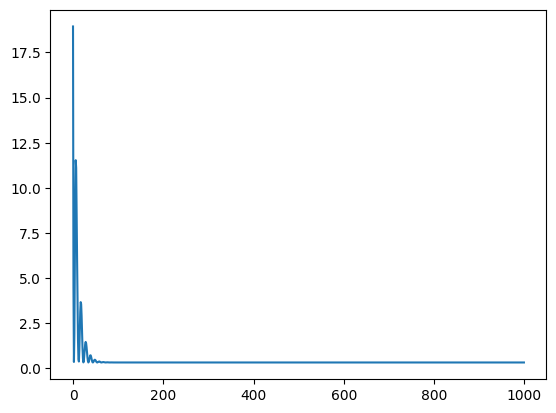

In [87]:
plt.plot(Energys_Adam)

/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


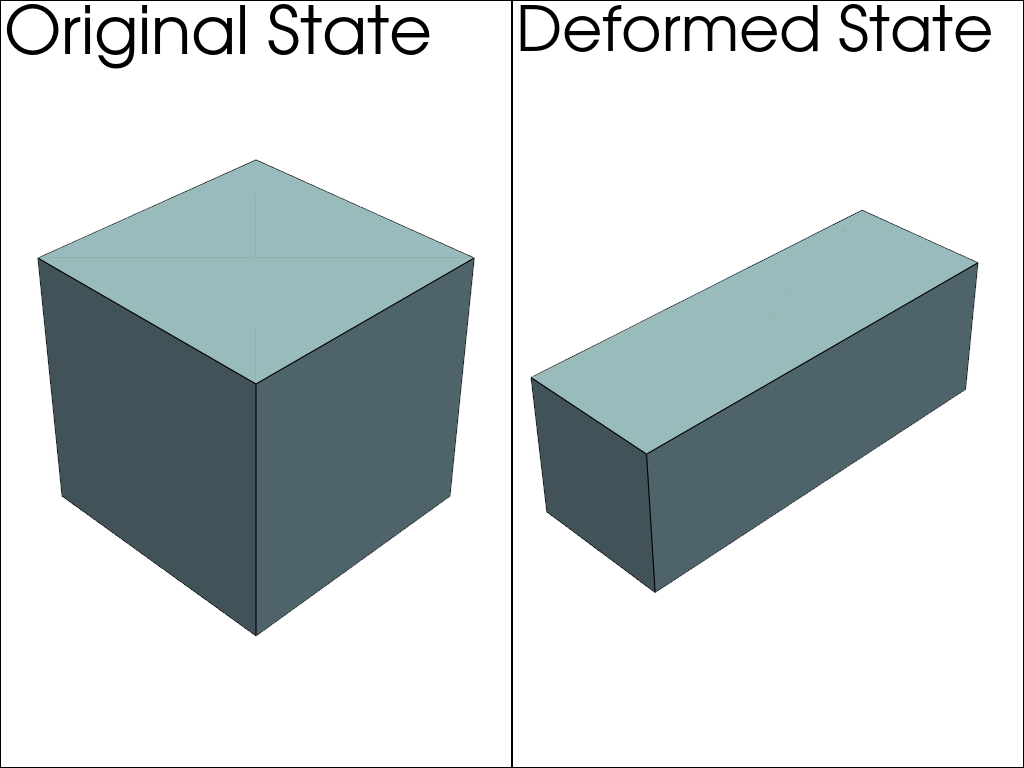

In [98]:
change_state_plot(mesh,u(disp_Adam))

In [99]:
print('Promedio J en los elementos: ',jnp.mean(jnp.linalg.det(malla.f(points_total+ u(disp_GD)))[0]))

Promedio J en los elementos:  1.0111384556734948


## 2x2 Cube

In [108]:
#Mesh SET

mesh_file = '/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Meshes/cube_2x2.msh'
mesh = pv.read(mesh_file)  #Orgiinal File
mesh.clear_data()

points_total,connectivity_total,bc_drichlet_cells,bc_neumann_cells = Hex_Reader(mesh_file,
                                                                                drichlet_bc= ["X_1"],plot = False)


#Dritchlet condition 
bc_drichlet_cells['X_1'] = [bc_drichlet_cells['X_1'], jnp.array([1,0,0]) ]

constant = [0.03,3.77]
material = mat.Delphino(constant,100)
malla = EL.Hexs(material, points_total,connectivity_total)

#Boundary_conditions

X_0_index = jnp.where(points_total[:, 0] == 0)[0]
X_1_index = jnp.where(points_total[:, 0] == 1)[0]
Y_0_index = jnp.where(points_total[:, 1] == 0)[0]
Z_0_index = jnp.where(points_total[:, 2] == 0)[0]


In [157]:
### Optimization 
#result = result.at[:4, :].set(0)
### Loss function
@jit
def loss_function(disp):
    disp = u(disp)
    constant = material.constants
    energia_externa = malla.External_Energy(disp, Dritchlet_BC = bc_drichlet_cells)
    energy_internal = malla.PSI(disp,constant)

    E_pot = energy_internal - energia_externa/1000

    return E_pot #+  (1 + E_pot/jnp.abs(E_pot))*100  

@jit
def u(disp):
    disp = disp.at[X_1_index,0].set(1)
    disp = disp.at[X_0_index,0].set(0)
    disp = disp.at[Y_0_index,1].set(0)
    disp = disp.at[Z_0_index,2].set(0)
    return disp


@jit
def Jacobian(disp):
    J = jax.jacrev(loss_function)(disp)
    #J = jax.grad(loss_2)(disp)
    
    return J



key, subkey = random.split(key)
disp_0  = jnp.zeros_like(points_total)#+random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1e-1) ##Zero initializaiton
# disp_0  = random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1.0)


In [158]:
## Optax Optimizer ADAM

start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

disp_Adam = disp_0

opt_state = optimizer.init(disp_Adam)
Energys_Adam  = []
for _ in range(2000):
  grads = Jacobian(disp_Adam)
  updates, opt_state = optimizer.update(grads, opt_state)
  disp_Adam = optax.apply_updates(disp_Adam, updates)
  Energys_Adam.append(loss_function(disp_Adam))

  # print(_)
  
print('Adam Energy Result',loss_function(disp_Adam)) 
# print(u(disp_Adam))

Adam Energy Result 0.32692219728638283


In [159]:
disp_file  ='/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Displacement_Tests/Cubo_Traccion_X_2x2.npy'
disp_FEM = np.load(disp_file)[-1,:,:]  # The order of this file is [time, node, dim]
print('Energia FEM ', loss_function(jnp.array(disp_FEM)))
# print(disp_FEM)

print(jnp.linalg.norm(disp_FEM - disp_Adam))

Energia FEM  0.3290631521557449
3.000140072703947


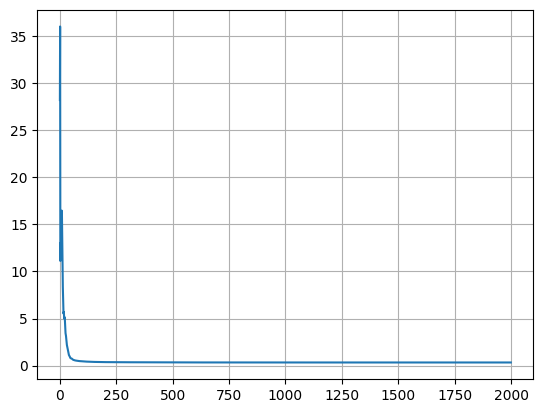

In [165]:
plt.plot(Energys_Adam, label = 'Loss function Adam Optimizer')
plt.grid()

/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


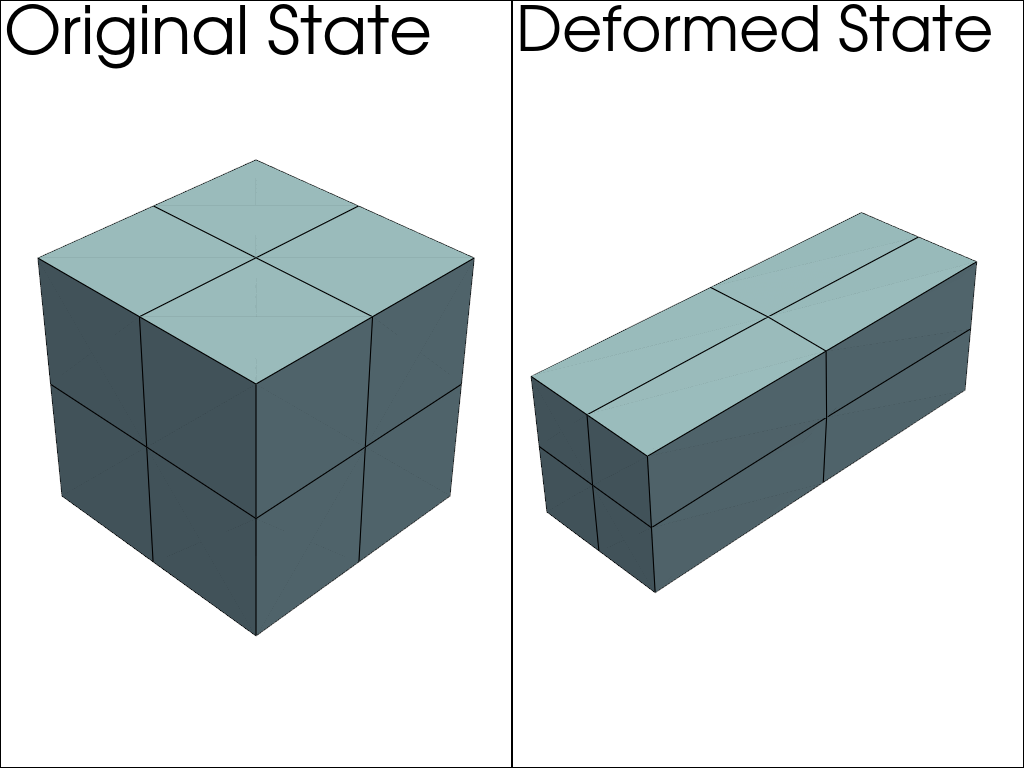

In [166]:
change_state_plot(mesh,u(disp_Adam))

In [156]:
print('Promedio J en los elementos: ',jnp.mean(jnp.linalg.det(malla.f(points_total+ u(disp_Adam)))[0]))

Promedio J en los elementos:  1.0113899867777643


In [148]:
disp_Adam

Array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.4855043 ],
       [ 0.        ,  0.        ,  0.47706344],
       [ 0.        , -0.88550691,  0.        ],
       [ 0.        ,  0.23058596,  0.        ],
       [ 0.        ,  0.62161429,  0.6729617 ],
       [ 0.        , -0.94898243,  0.87378392],
       [ 0.05073277,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.22561423],
       [ 0.64623257,  0.        , -0.65202511],
       [ 0.        ,  0.        , -0.34762624],
       [-0.22135742,  0.17983973,  0.        ],
       [ 0.        ,  0.21970874,  0.2137157 ],
       [ 1.17044633, -1.18685664,  0.42778916],
       [ 0.        , -0.76871785, -1.04659342],
       [ 0.        , -0.75166762,  0.        ],
       [ 0.        , -0.06968449,  0.        ],
       [ 0.        , -0.66176608,  0.60654818],
       [ 0.        ,  0.2435296 ,  0.08765939],
       [-0.19334647,  0.        , -0.706

In [149]:
disp_FEM

array([[ 0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.28788623],
       [ 1.        ,  0.        , -0.28788623],
       [ 0.        , -0.28788623,  0.        ],
       [ 1.        , -0.28788623,  0.        ],
       [ 1.        , -0.28788623, -0.28788623],
       [ 0.        , -0.28788623, -0.28788623],
       [ 0.5       ,  0.        ,  0.        ],
       [ 1.        ,  0.        , -0.14394312],
       [ 0.5       ,  0.        , -0.28788623],
       [ 0.        ,  0.        , -0.14394312],
       [ 0.5       , -0.28788623,  0.        ],
       [ 1.        , -0.28788623, -0.14394312],
       [ 0.5       , -0.28788623, -0.28788623],
       [ 0.        , -0.28788623, -0.14394312],
       [ 0.        , -0.14394312,  0.        ],
       [ 1.        , -0.14394312,  0.        ],
       [ 1.        , -0.14394312, -0.28788623],
       [ 0.        , -0.14394312, -0.28788623],
       [ 0.5       ,  0.        , -0.143